<img src='harrypotter_image.png' width='200px' style="float:left;margin-right:10pt"></img>
# Illustration of Static Hypergraphs using Kaggle's HarryPotter dataset.

In this tutorial we introduce `hypernetx.StaticEntity` and `hypernetx.StaticEntitySet` and the new `static=True` attribute in the `hypernetx.Hypergraph` class. 

Harry Potter Data is available here: https://www.kaggle.com/gulsahdemiryurek/harry-potter-dataset.

Python code for parsing the dataset is in `harrypotter.py` in this tutorial's directory.

In [1]:
import hypernetx as hnx
import networkx as nx
import matplotlib.pyplot as plt
from collections import OrderedDict, defaultdict
import scipy
from scipy.sparse import coo_matrix, csr_matrix, issparse
import pandas as pd
import numpy as np
import itertools as it
import sys
from harrypotter import HarryPotter

## The Harry Potter Dataset: 
To use a csv file for a Static Hypergraph, we need every cell filled with a label. 
We have edited the Harry Potter dataset so that it has 5 categories and every cell is filled. Where a value is unknown, we marked it as "Unknown *category_name*". 

In [2]:
hogwarts = HarryPotter()

In [3]:
hogwarts.dataframe

,House,Blood status,Species,Hair colour,Eye colour
0,Gryffindor,Half-blood,Human,Black,Bright green
1,Gryffindor,Pure-blood,Human,Red,Blue
2,Gryffindor,Muggle-born,Human,Brown,Brown
3,Gryffindor,Half-blood,Human,Silver| formerly auburn,Blue
4,Gryffindor,Part-Human,Half-Human/Half-Giant,Black,Black
...,...,...,...,...,...
135,Unknown House,Unknown Blood status,Human,Grey,Unknown Eye colour
136,Unknown House,Unknown Blood status,Werewolf,Grey,Unknown Eye colour
137,Unknown House,Pure-blood or half-blood,Human,Blond,Blue
138,Unknown House,Unknown Blood status,Elf,Unknown Hair colour,Unknown Eye colour


### We define a labeling based on the categories and store it in an Ordered Dictionary.
The ordering of labels is determined by their order of appearance in the table with the exception of Unknown labels, which are always listed first.

In [4]:
hogwarts.labels

OrderedDict([('House',
              array(['Unknown House', 'Gryffindor', 'Ravenclaw', 'Slytherin',
                     'Hufflepuff', 'Beauxbatons Academy of Magic',
                     'Durmstrang Institute'], dtype='<U28')),
             ('Blood status',
              array(['Unknown Blood status', 'Half-blood', 'Pure-blood', 'Muggle-born',
                     'Part-Human', 'Pure-blood or half-blood', 'Part-Goblin',
                     'Muggle-born or half-blood', 'Quarter-Veela', 'Muggle', 'Squib'],
                    dtype='<U25')),
             ('Species',
              array(['Unknown Species', 'Human', 'Half-Human/Half-Giant', 'Werewolf',
                     'Human (Werewolf traits)', 'Human(goblin ancestry)', 'Ghost',
                     'Centaur', 'Human (Metamorphmagus)', 'Elf'], dtype='<U23')),
             ('Hair colour',
              array(['Unknown Hair colour', 'Black', 'Red', 'Brown',
                     'Silver| formerly auburn', 'Blond', 'Sandy', 'Auburn',
 

### We next create a tensor with dimension equal to the number of categories and indexed by the labels. 
We encode the data in each column using a sequence of integers and store the coded data along with translator functions to retrieve the original names as needed. Here we remove duplicate rows but counts could be collected for a weighting scheme.

In [5]:
## List of nonzero indices
hogwarts.data

array([[ 0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0],
       [ 0,  0,  1,  1,  0],
       [ 0,  0,  1,  1,  3],
       [ 0,  0,  1,  1,  4],
       [ 0,  0,  1,  2,  3],
       [ 0,  0,  1, 19,  0],
       [ 0,  0,  1, 19, 25],
       [ 0,  0,  1, 26, 18],
       [ 0,  0,  3, 19,  0],
       [ 0,  0,  6, 20,  4],
       [ 0,  0,  7, 16, 15],
       [ 0,  0,  9,  0,  0],
       [ 0,  1,  1, 19, 22],
       [ 0,  1,  1, 29,  3],
       [ 0,  2,  1,  2,  7],
       [ 0,  2,  1, 15,  0],
       [ 0,  2,  1, 18,  4],
       [ 0,  2,  1, 19,  0],
       [ 0,  2,  1, 19, 17],
       [ 0,  2,  1, 27, 20],
       [ 0,  2,  1, 31, 23],
       [ 0,  5,  1,  0,  0],
       [ 0,  5,  1,  1,  0],
       [ 0,  5,  1,  3, 19],
       [ 0,  5,  1,  5,  2],
       [ 0,  5,  1, 10,  9],
       [ 0,  5,  1, 15,  0],
       [ 0,  5,  1, 19,  0],
       [ 0,  5,  1, 21, 14],
       [ 0,  5,  1, 25,  0],
       [ 0,  5,  1, 30,  3],
       [ 0,  9,  1,  1,  0],
       [ 0,  9,  1,  5,  2],
       [ 0,  9

In [6]:
hogwarts.data.shape

(126, 5)

In [7]:
hogwarts.arr

array([[[[[1, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         [[1, 0, 0, ..., 0, 0, 0],
          [1, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         ...,

         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
       

In [8]:
hogwarts.arr.shape

(7, 11, 10, 36, 26)

## StaticEntity and StaticEntitySet

The entire dataset has now been represented using a data array or tensor array and a dictionary associating positions in the tensor array and values in the data array with values in the original data.

The basic object in HyperNetX, which holds the data and label dictionary for a static hypergraph, is a `StaticEntity`.

Each dimension of the array, is considered a **level** in the StaticEntity. A level's order corresponds to its position in the datatable. In terms of the original Entity structure in HyperNetX, levels 'loosely' reference an order of containment. Elements of the the 2nd level belong to elements in the 1st column. Pairwise one can say the elements of one level belong to the elements of its predecessor column. The order of levels is given by the order of keys in the labels:

In [9]:
E = hnx.StaticEntity(arr = hogwarts.arr, labels = hogwarts.labels)
E.keys

array(['House', 'Blood status', 'Species', 'Hair colour', 'Eye colour'],
      dtype='<U12')

### A StaticEntitySet is a StaticEntity restricted to two levels. 
By default, a StaticEntity will grab the 1st two dimensions of the of the array and first two keys of the labels, but any pair of levels may be specified. 

In [10]:
ES = hnx.StaticEntitySet(E)
ES.labels

OrderedDict([('House',
              array(['Unknown House', 'Gryffindor', 'Ravenclaw', 'Slytherin',
                     'Hufflepuff', 'Beauxbatons Academy of Magic',
                     'Durmstrang Institute'], dtype='<U28')),
             ('Blood status',
              array(['Unknown Blood status', 'Half-blood', 'Pure-blood', 'Muggle-born',
                     'Part-Human', 'Pure-blood or half-blood', 'Part-Goblin',
                     'Muggle-born or half-blood', 'Quarter-Veela', 'Muggle', 'Squib'],
                    dtype='<U25'))])

## Static Hypergraph
A static hypergraph is one where all nodes and edges are known at the time of construction. This permits an internal ordering and uid structure for easy reference and faster computation of metrics.




In [11]:
H = hnx.Hypergraph(ES,static=True,use_nwhy=True)
H.edges

StaticEntitySet(None,['Gryffindor', 'Beauxbatons Academy of Magic', 'Slytherin', 'Durmstrang Institute', 'Ravenclaw', 'Hufflepuff', 'Unknown House'],{'counts': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])})

In [12]:
H.nodes

StaticEntitySet(None,['Muggle', 'Part-Goblin', 'Part-Human', 'Pure-blood or half-blood', 'Muggle-born', 'Quarter-Veela', 'Half-blood', 'Unknown Blood status', 'Muggle-born or half-blood', 'Squib', 'Pure-blood'],{})

In [13]:
H.incidence_matrix().todense()

matrix([[1, 1, 1, 0, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 0],
        [1, 1, 0, 1, 1, 0, 0],
        [0, 1, 1, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 1, 0],
        [1, 1, 1, 1, 1, 0, 1],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0]])

In [14]:
H.state_dict

{'data': (array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4,
         4, 4, 4, 4, 5, 5, 6]),
  array([ 0,  1,  2,  5,  9, 10,  0,  1,  2,  3,  4,  5,  0,  1,  3,  5,  6,
          7,  1,  2,  5,  0,  1,  2,  3,  5,  4,  8,  5]),
  array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1])),
 'snodelg': {},
 'sedgelg': {},
 'g': <nwhy.NWHypergraph at 0x7fae687b64b0>,
 'incidence_matrix': <11x7 sparse matrix of type '<class 'numpy.int64'>'
 	with 29 stored elements in Compressed Sparse Row format>}

In [15]:
H.dataframe()

,Unknown House,Gryffindor,Ravenclaw,Slytherin,Hufflepuff,Beauxbatons Academy of Magic,Durmstrang Institute
Unknown Blood status,1,1,1,0,1,0,0
Half-blood,1,1,1,1,1,0,0
Pure-blood,1,1,0,1,1,0,0
Muggle-born,0,1,1,0,1,0,0
Part-Human,0,1,0,0,0,1,0
Pure-blood or half-blood,1,1,1,1,1,0,1
Part-Goblin,0,0,1,0,0,0,0
Muggle-born or half-blood,0,0,1,0,0,0,0
Quarter-Veela,0,0,0,0,0,1,0
Muggle,1,0,0,0,0,0,0


### Restrict to specific edges and nodes

In [16]:
HF = H.restrict_to_edges(['Gryffindor','Ravenclaw','Slytherin','Hufflepuff'])
HF.dataframe()

,Gryffindor,Ravenclaw,Slytherin,Hufflepuff
Unknown Blood status,1,1,0,1
Half-blood,1,1,1,1
Pure-blood,1,0,1,1
Muggle-born,1,1,0,1
Part-Human,1,0,0,0
Pure-blood or half-blood,1,1,1,1
Part-Goblin,0,1,0,0
Muggle-born or half-blood,0,1,0,0


StaticEntitySet(None,['Gryffindor', 'Beauxbatons Academy of Magic', 'Slytherin', 'Durmstrang Institute', 'Ravenclaw', 'Hufflepuff', 'Unknown House'],{'counts': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])})

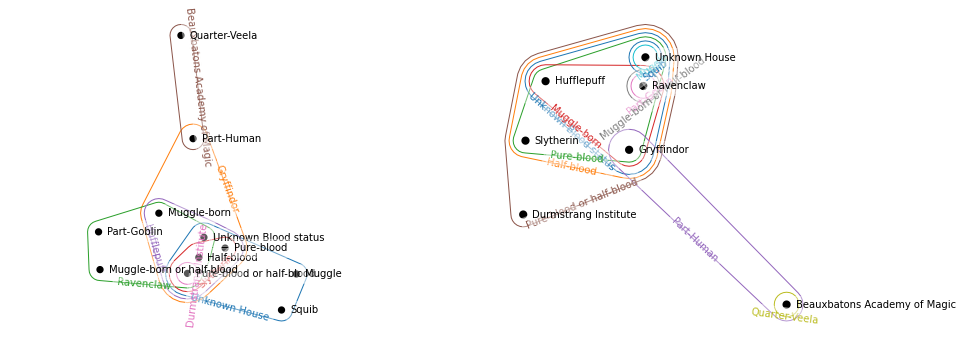

In [17]:
fig,ax = plt.subplots(1,2,figsize=(15,6))
hnx.draw(H,ax=ax[0]);
hnx.draw(H.dual())
H.edges

## Collapse identical elements
This method exists to collapse identical nodes and edges and is implemented for dynamic hypergraphs.
We wish to do the same for large unwieldy hypergraphs stored as static.

In [18]:
pos = {'Unknown House': np.array([-0.10670759,  0.39625995]), 'Gryffindor': np.array([-0.32244912,  0.27409625]), 'Ravenclaw': np.array([0.57391404, 0.27217292]), 'Hufflepuff': np.array([-0.02345858,  0.16025175]), 'Slytherin': np.array([-0.02249078, -0.50964294]), 'Durmstrang Institute': np.array([-0.08558045, -1.        ]), 'Unknown Blood status': np.array([0.15155363, 0.65523899]), 'Half-blood': np.array([0.24364009, 0.04186756]), 'Pure-blood': np.array([-0.45423213, -0.07752039]), 'Pure-blood or half-blood': np.array([ 0.04581088, -0.21272409])}

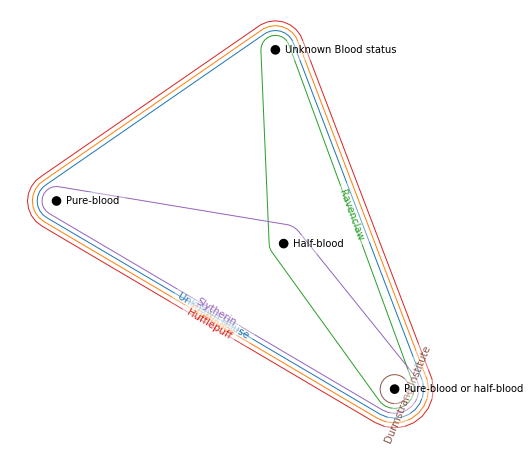

In [32]:
nodes = ['Pure-blood or half-blood',  'Unknown Blood status', 'Pure-blood', 'Half-blood',  ]
Hn = H.restrict_to_nodes(nodes)
hnx.draw(Hn,pos=pos)

OrderedDict([('Unknown House:3',
              ['Unknown House', 'Gryffindor', 'Hufflepuff']),
             ('Ravenclaw:1', ['Ravenclaw']),
             ('Slytherin:1', ['Slytherin']),
             ('Durmstrang Institute:1', ['Durmstrang Institute'])])

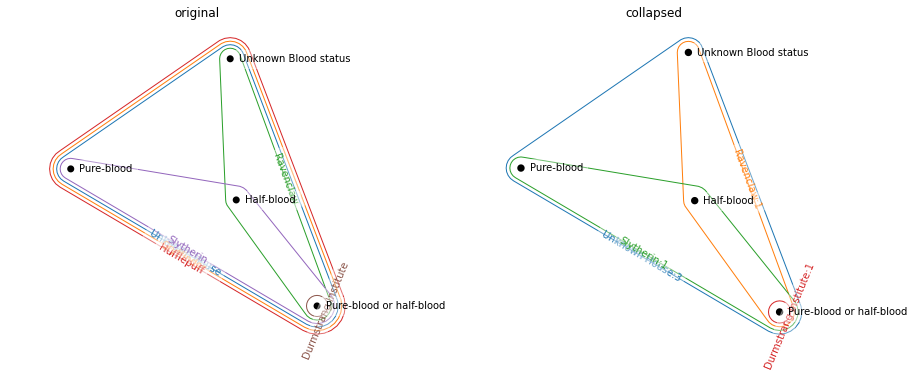

In [33]:
Hc,clses = Hn.collapse_edges(return_equivalence_classes=True)

## now draw the dynamic versions
fig,ax = plt.subplots(1,2,figsize=(15,6))
hnx.draw(Hn.remove_static(),ax=ax[0],pos=pos);
ax[0].set_title('original')
hnx.draw(Hc,ax=ax[1],pos=pos);
ax[1].set_title('collapsed');
clses

### Hypergraph methods apply to both static and dynamic hypergraphs

In [21]:
H.isstatic

True

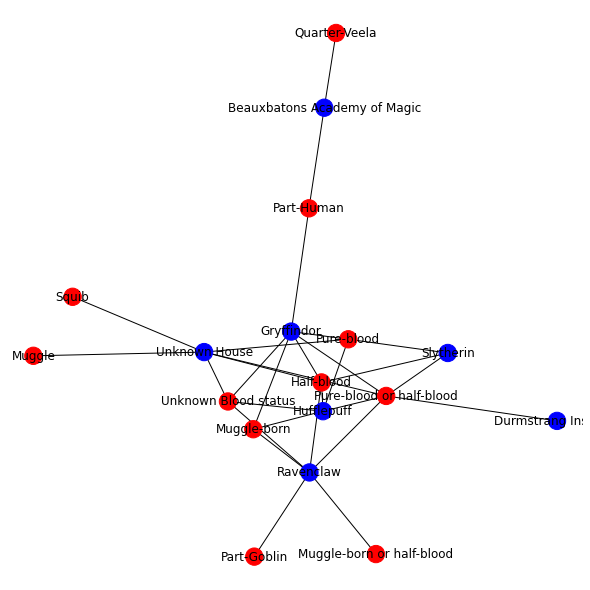

In [22]:
G = H.bipartite()
cmap = ['r' if G.nodes[n]['bipartite']==0 else 'b' for n in G.nodes ]
nx.draw(H.bipartite(),node_color=cmap,with_labels=True)

In [23]:
print(hnx.info(H))

Number of Rows: 11
Number of Columns: 7
Aspect Ratio: 1.5714285714285714
Number of non-empty Cells: 29
Density: 0.37662337662337664


In [29]:
## Once the dist stats are computed, they are stored in the state dict for fast recall and reference
hnx.dist_stats(H)

{'nrows': 11,
 'ncols': 7,
 'aspect ratio': 1.5714285714285714,
 'ncells': 29,
 'density': 0.37662337662337664,
 'node degree list': [6, 5, 4, 4, 3, 2, 1, 1, 1, 1, 1],
 'node degree centrality stats': {'min': 1,
  'max': 6,
  'mean': 2.6363636363636362,
  'median': 2.0,
  'std': 1.7721444263289026},
 'node degree hist': Counter({6: 1, 5: 1, 4: 2, 3: 1, 2: 1, 1: 5}),
 'max node degree': 6,
 'edge size list': [6, 6, 6, 5, 3, 2, 1],
 'edge size centrality stats': {'min': 1,
  'max': 6,
  'mean': 4.142857142857143,
  'median': 5.0,
  'std': 1.9587584572574412},
 'edge size hist': Counter({6: 3, 5: 1, 3: 1, 2: 1, 1: 1}),
 'max edge size': 6,
 'comp nodes list': [11],
 'comp nodes hist': Counter({11: 1}),
 'comp nodes centrality stats': {'min': 11,
  'max': 11,
  'mean': 11.0,
  'median': 11.0,
  'std': 0.0},
 'comp edges list': [7],
 'comp edges hist': Counter({7: 1}),
 'comp edges centrality stats': {'min': 7,
  'max': 7,
  'mean': 7.0,
  'median': 7.0,
  'std': 0.0},
 'num comps': 1}

In [30]:
H.state_dict

{'data': (array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4,
         4, 4, 4, 4, 5, 5, 6]),
  array([ 0,  1,  2,  5,  9, 10,  0,  1,  2,  3,  4,  5,  0,  1,  3,  5,  6,
          7,  1,  2,  5,  0,  1,  2,  3,  5,  4,  8,  5]),
  array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1])),
 'snodelg': {1: <nwhy.Slinegraph at 0x7fae6880f830>},
 'sedgelg': {1: <nwhy.Slinegraph at 0x7fae68805470>},
 'g': <nwhy.NWHypergraph at 0x7fae687b64b0>,
 'incidence_matrix': <11x7 sparse matrix of type '<class 'numpy.int64'>'
 	with 29 stored elements in Compressed Sparse Row format>,
 'edge_size_dist': [6, 6, 6, 3, 5, 2, 1],
 'dist_stats': {'nrows': 11,
  'ncols': 7,
  'aspect ratio': 1.5714285714285714,
  'ncells': 29,
  'density': 0.37662337662337664,
  'node degree list': [6, 5, 4, 4, 3, 2, 1, 1, 1, 1, 1],
  'node degree centrality stats': {'min': 1,
   'max': 6,
   'mean': 2.6363636363636362,
   'median': 2.0,
   'std': 1.772144

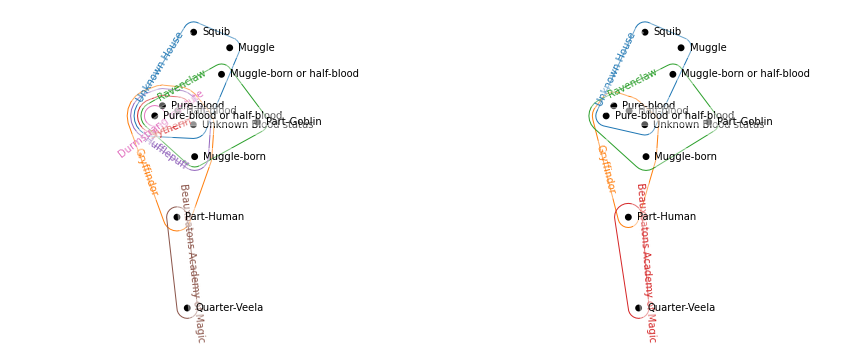

In [35]:
fig,ax = plt.subplots(1,2,figsize=(15,6))
pos = hnx.draw(H,ax=ax[0],return_pos=True)
hnx.draw(H.toplexes(),ax=ax[1],pos=pos)

In [27]:
H.collapse_edges()

Hypergraph(OrderedDict([('Unknown House:1', ['Unknown Blood status', 'Half-blood', 'Pure-blood', 'Pure-blood or half-blood', 'Muggle', 'Squib']), ('Gryffindor:1', ['Unknown Blood status', 'Half-blood', 'Pure-blood', 'Pure-blood or half-blood', 'Muggle-born', 'Part-Human']), ('Ravenclaw:1', ['Unknown Blood status', 'Half-blood', 'Pure-blood or half-blood', 'Muggle-born', 'Part-Goblin', 'Muggle-born or half-blood']), ('Slytherin:1', ['Half-blood', 'Pure-blood', 'Pure-blood or half-blood']), ('Hufflepuff:1', ['Unknown Blood status', 'Half-blood', 'Pure-blood', 'Pure-blood or half-blood', 'Muggle-born']), ('Beauxbatons Academy of Magic:1', ['Part-Human', 'Quarter-Veela']), ('Durmstrang Institute:1', ['Pure-blood or half-blood'])]),name=)

In [28]:
H.state_dict

{'data': (array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4,
         4, 4, 4, 4, 5, 5, 6]),
  array([ 0,  1,  2,  5,  9, 10,  0,  1,  2,  3,  4,  5,  0,  1,  3,  5,  6,
          7,  1,  2,  5,  0,  1,  2,  3,  5,  4,  8,  5]),
  array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1])),
 'snodelg': {1: <nwhy.Slinegraph at 0x7fae6880f830>},
 'sedgelg': {1: <nwhy.Slinegraph at 0x7fae68805470>},
 'g': <nwhy.NWHypergraph at 0x7fae687b64b0>,
 'incidence_matrix': <11x7 sparse matrix of type '<class 'numpy.int64'>'
 	with 29 stored elements in Compressed Sparse Row format>,
 'edge_size_dist': [6, 6, 6, 3, 5, 2, 1],
 'dist_stats': {'nrows': 11,
  'ncols': 7,
  'aspect ratio': 1.5714285714285714,
  'ncells': 29,
  'density': 0.37662337662337664,
  'node degree list': [6, 5, 4, 4, 3, 2, 1, 1, 1, 1, 1],
  'node degree centrality stats': {'min': 1,
   'max': 6,
   'mean': 2.6363636363636362,
   'median': 2.0,
   'std': 1.772144